In [93]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
import lightgbm as lgb
import nltk
from bs4 import BeautifulSoup
import transformers

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sub = pd.read_csv('data/sample_submit.csv')

In [27]:
train.head(6)

,id,goal,country,duration,category1,category2,html_content,state
0,0,4001-5000,CH,29,publishing,young adult,"<div class=""contents""><div><span class=""bold"">...",0
1,1,3001-4000,NL,34,fashion,ready-to-wear,"<div class=""contents""><div><h1 class=""page-anc...",0
2,2,19001-20000,US,30,food,spaces,"<div class=""contents""><div><p> As our society ...",0
3,3,2001-3000,US,41,technology,3d printing,"<div class=""contents""><div><p>My name is Donal...",0
4,4,2001-3000,GB,29,technology,diy electronics,"<div class=""contents""><div><div class=""templat...",1
5,5,1-1000,US,19,photography,fine art,"<div class=""contents""><div><h1 class=""page-anc...",1


In [44]:
html_0 = train.html_content[2]
print(html_0)

<div class="contents"><div><p> As our society begins to wake up from the hangover of unconscionable waste, we need to turn to the model of nature and learn how to conserve and reuse our resources. Instead of throwing chemicals into a sterile system, aquaponics creates a harmonious cycle that saves water, energy and waste that can serve as a centerpiece to your room as a living reminder to the responsibility we have to future generations while at the same time providing food and keeping your pets healthy,happy and beautiful.   </p><p>Our website: www.hnuqiponics.com</p><div class="template asset" contenteditable="false" data-alt-text="Prototype generation 5 complete system" data-caption="Prototype generation 5 complete system" data-id="_xxx_">
<figure>
<img alt="Prototype generation 5 complete system" class="fit lazyload" data-src="http://dummy.com"/>
<figcaption class="px2">Prototype generation 5 complete system</figcaption>
</figure>
</div>
<p> </p>
<div class="template asset" content

In [53]:
raw = BeautifulSoup(html_0).get_text()
print(raw)

 As our society begins to wake up from the hangover of unconscionable waste, we need to turn to the model of nature and learn how to conserve and reuse our resources. Instead of throwing chemicals into a sterile system, aquaponics creates a harmonious cycle that saves water, energy and waste that can serve as a centerpiece to your room as a living reminder to the responsibility we have to future generations while at the same time providing food and keeping your pets healthy,happy and beautiful.   Our website: www.hnuqiponics.com


Prototype generation 5 complete system


 



assembled prototype 5 system


Have you ever wanted to keep fish but the constant maintenance and cleaning scares you off? Do you enjoy fresh herbs when you cook but haven't been able to successfully keep a fresh herb garden? Do you live in a climate where the growing season is very short? Have you ever wanted to keep some exotic flowering plants but found the care to be overwhelming? What if there was a system th

In [62]:
def remove_nl_tag(raw_text):
    raw_text = raw_text.replace(u"\n", u"")
    return raw_text

In [66]:
def remove_nobreak_space(raw_text):
    raw_text = raw_text.replace(u'\xa0', u' ')
    return raw_text

In [64]:
raw_1= remove_nl_tag(raw)
print(raw_1)

 As our society begins to wake up from the hangover of unconscionable waste, we need to turn to the model of nature and learn how to conserve and reuse our resources. Instead of throwing chemicals into a sterile system, aquaponics creates a harmonious cycle that saves water, energy and waste that can serve as a centerpiece to your room as a living reminder to the responsibility we have to future generations while at the same time providing food and keeping your pets healthy,happy and beautiful.   Our website: www.hnuqiponics.comPrototype generation 5 complete system assembled prototype 5 systemHave you ever wanted to keep fish but the constant maintenance and cleaning scares you off? Do you enjoy fresh herbs when you cook but haven't been able to successfully keep a fresh herb garden? Do you live in a climate where the growing season is very short? Have you ever wanted to keep some exotic flowering plants but found the care to be overwhelming? What if there was a system that would allo

In [16]:
text = raw

In [18]:
from transformers import BertTokenizer, BertForSequenceClassification
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

token = bert_tokenizer.encode_plus(
                        text,                       # Sentence to encode.
                        add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                        max_length = None,  # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,  # Construct attn. masks.
                   )

ids = token['input_ids']
mask = token['attention_mask']

Token indices sequence length is longer than the specified maximum sequence length for this model (563 > 512). Running this sequence through the model will result in indexing errors


In [22]:
len(ids)

563

In [23]:
def check_length_with_berttokenizer(bert_tokenizer, text):
    token = bert_tokenizer.encode_plus(
                            text,                       # Sentence to encode.
                            add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                            max_length = None,  # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,  # Construct attn. masks.
                       )
    ids = token['input_ids']
    return len(ids)

In [38]:
lengths = []
for i, html in tqdm(enumerate(train.html_content)):
    text = BeautifulSoup(html).get_text()
    length = check_length_with_berttokenizer(bert_tokenizer, text)
    lengths.append(length)
print(max(lengths))

0it [00:00, ?it/s]/Applications/anaconda3/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1938: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
10545it [02:14, 78.56it/s] 

8176


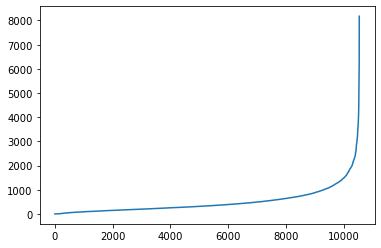

In [43]:
plt.figure()
plt.plot(sorted(lengths))

In [33]:
def count_number_of_figure(html_text):
    count_fig = html_text.count("<figure>")
    count_fig_end = html_text.count("</figure>")
    if not count_fig == count_fig_end:
        return None
    return count_fig

In [34]:
count_number_of_figure(html_0)

15

In [51]:
def count_number_of_video(html_text):
    #count_fig = html_text.count("<video>")
    count_video_end = html_text.count("</video>")
    #if not count_fig == count_fig_end:
     #   return None
    return count_video_end

In [52]:
html_2 = train.html_content[2]
n = count_number_of_video(html_2)
print(n)

1


In [154]:
def extract_each_paragraphs(html_text):
    paragraphs = []
    para_list = html_text.split("<p>")
    if not "<p>" in html_text[0:4]:
        para_list = para_list[1:]
    for para in para_list:
        if "</p>" in para:
            para_new = para.split("</p>")[0]
        else:
            para_new = ""
            
        #それでも残っているhtmlタグを取り除く(要らないかも)
        para_new = BeautifulSoup(para_new).get_text()
        #para_new = remove_nobreak_space(para_new)
        
        paragraphs.append(para_new)
    try:
        paragraphs.remove("")
    except:
        pass
    try:
        paragraphs.remove(" ")
    except:
        pass
    try:
        paragraphs.remove(u"\xa0")
    except:
        pass
    
    return paragraphs

In [136]:
para_lis = extract_each_paragraphs(html_0)
for para in para_lis:
    print(para)

 As our society begins to wake up from the hangover of unconscionable waste, we need to turn to the model of nature and learn how to conserve and reuse our resources. Instead of throwing chemicals into a sterile system, aquaponics creates a harmonious cycle that saves water, energy and waste that can serve as a centerpiece to your room as a living reminder to the responsibility we have to future generations while at the same time providing food and keeping your pets healthy,happy and beautiful.   
Our website: www.hnuqiponics.com
Have you ever wanted to keep fish but the constant maintenance and cleaning scares you off? Do you enjoy fresh herbs when you cook but haven't been able to successfully keep a fresh herb garden? Do you live in a climate where the growing season is very short? Have you ever wanted to keep some exotic flowering plants but found the care to be overwhelming? What if there was a system that would allow you to raise fish and plants with little maintenance and withou

In [98]:
class HtmlDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.csv_file = csv_file
        self.transform = transform
        
    
    def __len__(self):
        return len(self.csv_file)
    
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        html_text = self.csv_file.html_content.iloc[idx]
        try:
            label = self.csv_file.state.iloc[idx]
        except:
            label = self.csv_file.id.iloc[idx]
            
        if self.transform:
            text = self.transform(html_text)
            
        return html_text, label

In [100]:
train_dataset = HtmlDataset(train)

In [155]:
print(train_dataset[14][0])
print("\n")
print(BeautifulSoup(train_dataset[14][0]).get_text())
print("\n")
print(" ".join(extract_each_paragraphs(train_dataset[14][0])))

<div class="contents"><div><p>"Streetball is usually only about such things as no-look passes, behind-the-back dribbles and rim-rocking dunks."</p><p>But we made it about something more by organizing the second Iris Fazio Memorial Tournament on Saturday August 9th. Paying tribute to my  grandmother who passed away eight years ago and helping spread the love of basketball in her community. </p><p>The tournament will be comprised of approximately 60 players from Riverdale and Kingsbridge, divided into eight teams. It will be held at the Spuyten Duyvil Playground basketball courts on West 236th Street.</p><p>In an effort to show sportsmanship, teamwork, and the excitement of sports, I hope to create an event that the community can count on bringing core values to our city youth.</p><p>I got quotes from all vendors for jerseys, trophies, equipment, refs, and a videographer. The total comes to around $1,700. This is the bare bones budget needed for this tournament to be realized this year.<

In [110]:
raw = BeautifulSoup(train_dataset[4][0]).get_text()
raw = remove_nl_tag(raw)
print(raw)

We all love to play, don't we! No matter the age... :) And we are also the techie generation for the STEM basics. (Psst... Its alright if you are new to this, you can still read the story ahead). So, we at SB Components came out with a concept where we decided to give the pleasure of both programming and playing, together. After all:We wanted to design and develop something that can help any one (technical or non-technical) explore their vision of creating something cool while on the play! And this was made even better by introducing the popular micro-controller BBC micro:bit board.For those new to the micro:bit community, here is a short summary of "What micro:bit is all about" and what this tiny board is capable of. This time, we wanted to explore our ideas for the micro:bit (unlike our other campaigns). The micro:bit was the most recent project by the BBC in an effort to bring computer science education and STEM topics to every student worldwide. It is now so popular that every make

In [124]:
para_lis = extract_each_paragraphs(train_dataset[4][0])
raw = ""
for para in para_lis:
    para = remove_nl_tag(para)
    para = remove_nobreak_space(para)
    raw += para
    
print(raw)

We all love to play, don't we! No matter the age... :) And we are also the techie generation for the STEM basics. (Psst... Its alright if you are new to this, you can still read the story ahead). So, we at SB Components came out with a concept where we decided to give the pleasure of both programming and playing, together. After all:We wanted to design and develop something that can help any one (technical or non-technical) explore their vision of creating something cool while on the play! And this was made even better by introducing the popular micro-controller BBC micro:bit board.For those new to the micro:bit community, here is a short summary of "What micro:bit is all about" and what this tiny board is capable of. This time, we wanted to explore our ideas for the micro:bit (unlike our other campaigns). The micro:bit was the most recent project by the BBC in an effort to bring computer science education and STEM topics to every student worldwide. It is now so popular that every make

In [125]:
raw

'We all love to play, don\'t we! No matter the age... :) And we are also the techie generation for the STEM basics. (Psst... Its alright if you are new to this, you can still read the story ahead). So, we at SB Components came out with a concept where we decided to give the pleasure of both programming and playing, together. After all:We wanted to design and develop something that can help any one (technical or non-technical) explore their vision of creating something cool while on the play! And this was made even better by introducing the popular micro-controller BBC micro:bit board.For those new to the micro:bit community, here is a short summary of "What micro:bit is all about" and what this tiny board is capable of. This time, we wanted to explore our ideas for the micro:bit (unlike our other campaigns). The micro:bit was the most recent project by the BBC in an effort to bring computer science education and STEM topics to every student worldwide. It is now so popular that every ma

In [126]:
"""
連続スペース　＞　一つのスペース
we\'d > we'd

など　正規化
"""

"\n連続スペース\u3000＞\u3000一つのスペース\nwe'd > we'd\n\nなど\u3000正規化\n"